In [45]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [52]:
def save_fig(fig_id, tight_layout= True, fig_extension= 'png', resolution= 300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format= fig_extension, dpi= resolution)
    
def plot_digit(data):
    image = data.shape(28, 28)
    plt.imshow(image, cmap= mpl.cm.binary,
               interpolation= 'nearest')
    plt.axis('off')
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis= 1))
    image = np.concatenate(row_images, axis= 0)
    plt.imshow(image, cmap= mpl.cm.binary, **options)
    plt.axis('off')
    
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
def plot_precision_recall_v_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label= 'Precision', linewidth= 2)
    plt.plot(thresholds, recalls[:-1], 'g-', label= 'Recall', linewidth= 2)
    plt.legend(loc= 'center right', fontsize = 16)
    plt.xlabel('Threshold', fontsize= 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth= 2)
    plt.xlabel('Recall', fontsize= 16)
    plt.ylabel('Precision', fontsize= 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth= 2, label=label)
    plt.plot([0, 1], [0., 1.], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Postive Rate (Fall-Out)', fontsize = 16)
    plt.ylabel('True Postive Rate (Recall)', fontsize = 16)
    plt.grid(True)

In [3]:
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

# MNIST

In [4]:
# fetch dataset for manipulation and analysis
mnist = fetch_openml('mnist_784', version= 1)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
# let's see the description of this dataset.  According to the book this dataset is famous and great to 
# practice you pattern recognition skills
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [7]:
# look at the arrays
X, y = mnist['data'], mnist['target']
print('features shape: ', X.shape)
print('target shape: ', y.shape)

features shape:  (70000, 784)
target shape:  (70000,)


In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

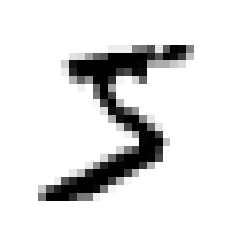

In [9]:
plt.imshow(some_digit_image, cmap= 'binary')
plt.axis('off')
plt.show()

In [10]:
y[0]

'5'

In [11]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

Saving figure more_digits_plot


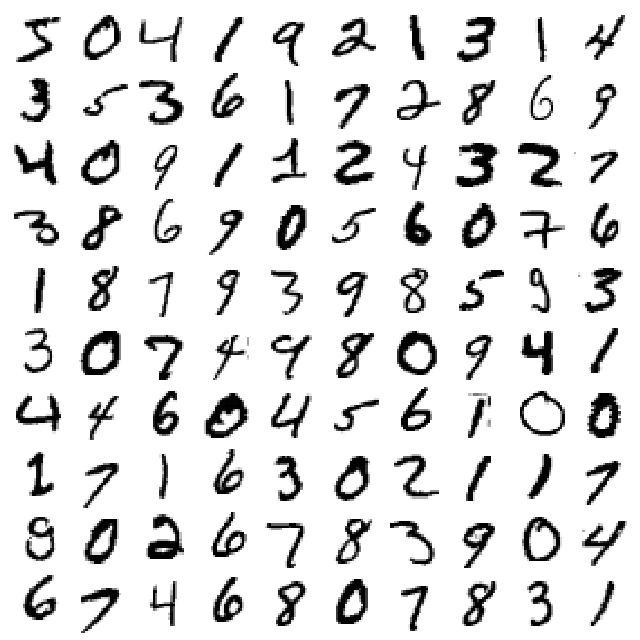

In [12]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row= 10)
save_fig('more_digits_plot')
plt.show()

## split train and test data

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## training a binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
sgd_clf = SGDClassifier(random_state=42)

In [16]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

## measuring accuracy using cross-validation

In [18]:
# this approach is used when you want to have more control on cross validation
skfolds= StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv= 3, scoring= 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Accuracy is high, but 5s represents 10% of the data.  Therefore, Accuracy is not a good metric for our model

In [20]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv= 3, scoring= 'accuracy')

array([0.91125, 0.90855, 0.90915])

## confusion matrix

In [21]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)

In [22]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]], dtype=int64)

## precision and recall

In [24]:
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
# decision function
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3,
                             method= 'decision_function')

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


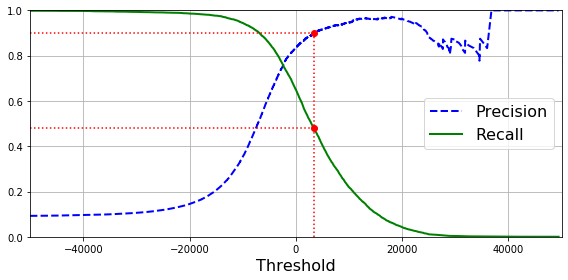

In [32]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize= (8,4))
plot_precision_recall_v_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")          

In [33]:
recall_90_precision

0.4799852425751706

In [34]:
threshold_90_precision

3370.0194991439557

In [35]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall


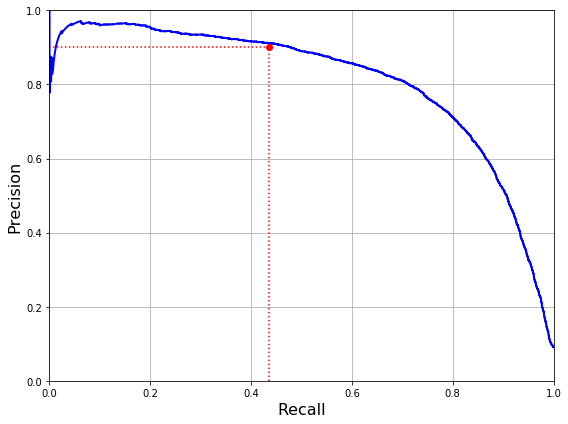

In [36]:
plt.figure(figsize= (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], 'r:')
plt.plot([0.0, 0.4368], [0.9, 0.9], 'r:')
plt.plot([0.4368], [0.9], 'ro')
save_fig('precision_vs_recall')

In [37]:
threshold_90_precision

3370.0194991439557

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC curves

In [41]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)   

Saving figure precision_vs_recall


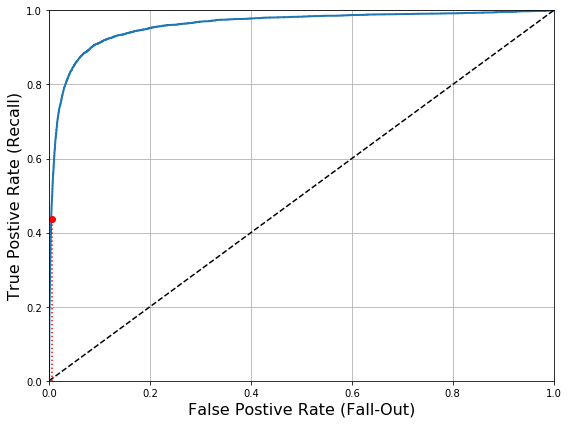

In [42]:
plt.figure(figsize= (8, 6))
plot_roc_curve(fpr, tpr, label=None)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:')
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:')
plt.plot([4.837e-3], [0.4368], 'ro')
save_fig('precision_vs_recall')

In [44]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [47]:
forest_clf = RandomForestClassifier(random_state= 42)
y_probas_forest= cross_val_predict(forest_clf, X_train, y_train_5, cv= 3,
                                   method= 'predict_proba')

In [48]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


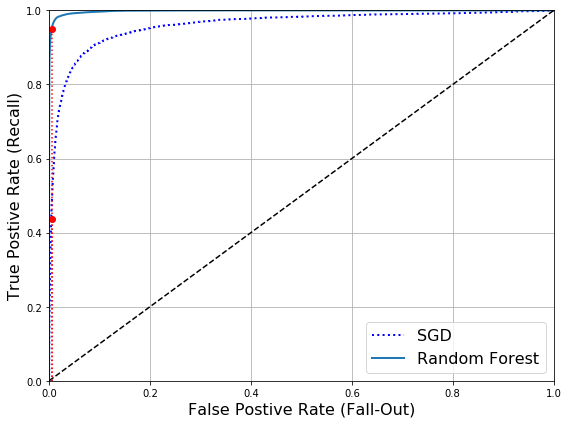

In [53]:
plt.figure(figsize= (8, 6))
plt.plot(fpr, tpr, 'b:', linewidth= 2, label= 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, label= 'Random Forest')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:')
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:')
plt.plot([4.837e-3], [0.4368], 'ro')
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], 'r:')
plt.plot([4.837e-3], [0.9487], 'ro')
plt.grid(True)
plt.legend(loc= 'lower right', fontsize= 16)
save_fig('roc_curve_comparison_plot')

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [57]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv= 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## multiclass classification